# Soccer Master

## EDA

# Collecting data from kaggle zipfile

In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import json
import os
import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
!dir "./Documents"

 Volume in drive C is OS
 Volume Serial Number is 9E78-A74A

 Directory of c:\Users\devdp\OneDrive\Documents\Github\UMBC\soccer_master



File Not Found


For easy access I have uploaded data to my drive. You can download it from here https://drive.google.com/file/d/1wGwuRD2XrQUofrUksJ9ar8-kpgWA5iTx/view?usp=sharing

In [3]:
def load_files_into_datasets():

    # If cache doesn't exist or is invalid, load from ZIP
    files = {}
    try:
        # Try Google Colab path first
        from google.colab import drive
        drive.mount('/content/drive')
        zipfile_path = '/content/drive/MyDrive/datasets/soccer_data.zip'
    except:
        # Fall back to local path
        zipfile_path = 'C:\\Users\\devdp\\OneDrive\\Documents\\Github\\UMBC\\soccer_master\\data\\soccer_data.zip'

    # Ensure ZIP file exists
    if not os.path.exists(zipfile_path):
        raise FileNotFoundError(f"ZIP file not found at {zipfile_path}")

    # Load data from ZIP
    with ZipFile(zipfile_path) as zip_file:
        for file in zip_file.infolist():
            if file.filename.endswith('.csv'):
                filename = file.filename.split('.csv')[0]
                with zip_file.open(file.filename) as f:
                    files[filename] = pd.read_csv(f)

    return files

files = load_files_into_datasets()

In [4]:
files.keys()

dict_keys(['clubs', 'club_games', 'players', 'games', 'game_lineups', 'transfers', 'player_valuations', 'game_events', 'competitions', 'appearances'])

In [5]:
df = []
for key, value in files.items():
    df.append([key.split('_df')[0]+'.csv', value.shape[0], value.shape[1], ','.join(value.columns)])

data_info=pd.DataFrame(df, columns=['file', 'rows', 'columns', 'column_names'])
data_info.to_csv('data_info.csv', index=False)
print("Data Info:")
print("="*100)
print(data_info)
print("="*100)

Data Info:
                    file     rows  columns  \
0              clubs.csv      439       17   
1         club_games.csv   142052       11   
2            players.csv    32407       23   
3              games.csv    71026       23   
4       game_lineups.csv  2191911       10   
5          transfers.csv    77932       10   
6  player_valuations.csv   487931        5   
7        game_events.csv   986885       10   
8       competitions.csv       44       11   
9        appearances.csv  1633394       13   

                                                                                                                                                                                                                                                                                                                                       column_names  
0                                                                                                         club_id,club_code,name,domestic_co

In [6]:
players = files['players']
transfers = files['transfers']
appearances = files['appearances']
game_events = files['game_events']
player_valuations = files['player_valuations']
clubs = files['clubs']
club_games = files['club_games']
games = files['games']
game_lineups = files['game_lineups']

## Separating all dataframes

# Data Preprocessing

## Helpers

In [7]:
def get_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a dataframe to represent the missing values in the original dataframe.

    Args:
        df (pd.DataFrame): Original dataframe to identify missing values.

    Returns:
        pd.DataFrame: New dataframe representing a report of missing values in original dataframe.
    """
    total_missing = df.isna().sum()
    total_available = len(df) - total_missing
    ratio_missing = total_missing / len(df)
    percent_missing = ratio_missing*100
    return pd.DataFrame({
        'total_missing': total_missing,
        'total_available': total_available,
        'ratio_missing': ratio_missing,
        'percent_missing': percent_missing.map(lambda p: f'{p:.1f}%')
    })

In [8]:
def convert_season_format(season_str: str) -> int:
    """
    Convert season string format (e.g., '93/94', '02/03') to starting year (e.g., 1993, 2002)

    Parameters
    ----------
    season_str : str
        Season in format 'YY/YY'

    Returns
    -------
    int
        Full year (e.g., 1993, 2002)
    """
    start_year = season_str.split('/')[0]

    # Convert to integer
    year_num = int(start_year)

    # If year is greater than 50, assume 1900s, otherwise 2000s
    if year_num > 50:
        return 1900 + year_num
    else:
        return 2000 + year_num

## Transfers dataframe



In [9]:
transfers['transfer_date'] = pd.to_datetime(transfers['transfer_date'])
transfers = transfers.sort_values(by="transfer_date")
transfers['transfer_fee'] = pd.to_numeric(transfers['transfer_fee'], errors='coerce')
transfers['market_value_in_eur'] = pd.to_numeric(transfers['market_value_in_eur'], errors='coerce')
transfers['season'] = transfers['transfer_season'].apply(convert_season_format)
transfers['season'] = pd.to_numeric(transfers['season'])
transfers.head()

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,season
77931,61989,1993-07-01,93/94,55345,55343,A. Ickern Yth.,VfR Rauxel Yth.,0.0,NaN,Michael Esser,1993
77928,22141,1994-07-01,94/95,59178,29463,Castellammare,Sorrento Youth,NaN,NaN,Antonio Mirante,1994
77930,40680,1994-07-01,94/95,47320,47318,Lichtenw. Yth.,Schornbach Yth.,0.0,NaN,Sven Ulreich,1994
77929,33829,1994-07-01,94/95,58405,53957,FC Penafiel You,Sporting Yth.,NaN,NaN,José Fonte,1994
77927,35207,1995-07-01,95/96,42281,11896,PTSV Dort. Yth.,Dortmund Yth.,0.0,NaN,Marco Reus,1995


Checking for nulls

In [10]:
get_missing_values(transfers)

,total_missing,total_available,ratio_missing,percent_missing
player_id,0,77932,0.000000,0.0%
transfer_date,0,77932,0.000000,0.0%
transfer_season,0,77932,0.000000,0.0%
from_club_id,0,77932,0.000000,0.0%
to_club_id,0,77932,0.000000,0.0%
from_club_name,0,77932,0.000000,0.0%
to_club_name,0,77932,0.000000,0.0%
transfer_fee,27157,50775,0.348470,34.8%
market_value_in_eur,29679,48253,0.380832,38.1%
player_name,0,77932,0.000000,0.0%


Filling 0 where player is retired or is a free agent

In [11]:
transfers.loc[transfers['to_club_name'].isin(['Retired', 'Without Club']), ['transfer_fee', 'market_value_in_eur']] = 0

Filling 0 where player promoted to first team

In [12]:
suffixes_to_remove = [' B', 'U16', 'U19', 'U20', 'U21', 'U18', 'U23', 'Yth.', 'IF','II', 'FC', 'AC', 'CF', 'RCD', 'Atl.', 'Ak.']

for suffix in suffixes_to_remove:
    transfers['from_club_name'] = transfers['from_club_name'].str.replace(suffix, '', regex=False)
    transfers['from_club_name'] = transfers['from_club_name'].str.strip()
    transfers['to_club_name'] = transfers['to_club_name'].str.replace(suffix, '', regex=False)
    transfers['to_club_name'] = transfers['to_club_name'].str.strip()

transfers.loc[transfers['from_club_name'] == transfers['to_club_name'], 'transfer_fee'] = 0

For furthur imputing of missing transfer values

1. Try finding players mean transfer fees and use that if it is not NaN
2. Try to find mean transfer fees based on clubs invoved of clubs and fill if its not NaN

In [13]:
print("#"*100)
print("Null values before imputing:", transfers['transfer_fee'].isna().sum())
print("#"*100)
print("\n")
avg_transfer_fees_by_player_id = transfers[transfers.player_id.isin(transfers[transfers.transfer_fee.isna()].player_id.unique())].groupby(['player_id'])['transfer_fee'].mean().reset_index().rename(columns={'transfer_fee': 'avg_transfer_fee_by_player'})


transfers = transfers.merge(avg_transfer_fees_by_player_id, on='player_id', how='left')
transfers['transfer_fee'].fillna(transfers['avg_transfer_fee_by_player'], inplace=True)
transfers.drop(columns=['avg_transfer_fee_by_player'], inplace=True)

print("#"*100)
print("Null values after first imputing:", transfers['transfer_fee'].isna().sum())
print("#"*100)
print("\n")


avg_transfer_fees_by_clubs = transfers[transfers.player_id.isin(transfers[transfers.transfer_fee.isna()].player_id.unique())].groupby(["from_club_id", "to_club_id"])['transfer_fee'].mean().reset_index().rename(columns={'transfer_fee': 'avg_transfer_fee_by_clubs'})
transfers = transfers.merge(avg_transfer_fees_by_clubs, on=['from_club_id', 'to_club_id'], how='left')
transfers['transfer_fee'].fillna(transfers['avg_transfer_fee_by_clubs'], inplace=True)
transfers.drop(columns=['avg_transfer_fee_by_clubs'], inplace=True)

print("#"*100)
print("Null values after second imputing:", transfers['transfer_fee'].isna().sum())
print("#"*100)
print("\n")

get_missing_values(transfers)
transfers[transfers.transfer_fee.isna()].head()

####################################################################################################
Null values before imputing: 18317
####################################################################################################


####################################################################################################
Null values after first imputing: 918
####################################################################################################


####################################################################################################
Null values after second imputing: 918
####################################################################################################




C:\Users\devdp\AppData\Local\Temp\ipykernel_13784\2821311398.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transfers['transfer_fee'].fillna(transfers['avg_transfer_fee_by_player'], inplace=True)
C:\Users\devdp\AppData\Local\Temp\ipykernel_13784\2821311398.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,season
577,172974,2005-01-01,04/05,20667,20529,Din. Kirov Y,Dinamo Kirov,NaN,NaN,Andrey Malykh,2004
4003,172974,2010-01-01,09/10,20529,14589,Dinamo Kirov,Gazovik Orenburg,NaN,NaN,Andrey Malykh,2009
5602,808664,2011-03-30,10/11,48262,30987,Aldrans,W. Innsbruck J.,NaN,NaN,Florian Micheler,2010
6468,478366,2011-07-01,11/12,58405,55166,Penafiel You,Paços,NaN,NaN,Miguel Reisinho,2011
6469,475407,2011-07-01,11/12,54530,54529,Vitória SC Y,Vitória SC U15,NaN,NaN,Dani Figueira,2011


Next logic:

4. Find if a transfer is player's first transfer and fill it by 0
5. Find where both transfer fee and market value is missing and drop those columns

In [14]:
condition = transfers[['transfer_fee', 'market_value_in_eur']].isna().all(axis=1)

# Identify the first transfer for each player
first_transfer = transfers.groupby('player_id').head(1).index

# Update only those rows where both 'transfer_fee' and 'market_value_in_eur' are NaN and it's the first transfer
transfers.loc[first_transfer[condition[first_transfer]], ['transfer_fee', 'market_value_in_eur']] = 0

print("#"*100)
print("Null values after third imputing:", transfers['transfer_fee'].isna().sum())
print("#"*100)
print("\n")

transfers = transfers[~transfers[['transfer_fee', 'market_value_in_eur']].isna().all(axis=1)]
transfers = transfers[~transfers['transfer_fee'].isna()]

print("#"*100)
get_missing_values(transfers)


####################################################################################################
Null values after third imputing: 523
####################################################################################################


####################################################################################################


,total_missing,total_available,ratio_missing,percent_missing
player_id,0,77409,0.0000,0.0%
transfer_date,0,77409,0.0000,0.0%
transfer_season,0,77409,0.0000,0.0%
from_club_id,0,77409,0.0000,0.0%
to_club_id,0,77409,0.0000,0.0%
from_club_name,0,77409,0.0000,0.0%
to_club_name,0,77409,0.0000,0.0%
transfer_fee,0,77409,0.0000,0.0%
market_value_in_eur,28711,48698,0.3709,37.1%
player_name,0,77409,0.0000,0.0%


Drop null values in market value column

In [15]:
# Filling missing market values bu transfer fee
transfers['market_value_in_eur'] = transfers['market_value_in_eur'].fillna(transfers['transfer_fee'])

In [16]:
get_missing_values(transfers)

,total_missing,total_available,ratio_missing,percent_missing
player_id,0,77409,0.0,0.0%
transfer_date,0,77409,0.0,0.0%
transfer_season,0,77409,0.0,0.0%
from_club_id,0,77409,0.0,0.0%
to_club_id,0,77409,0.0,0.0%
from_club_name,0,77409,0.0,0.0%
to_club_name,0,77409,0.0,0.0%
transfer_fee,0,77409,0.0,0.0%
market_value_in_eur,0,77409,0.0,0.0%
player_name,0,77409,0.0,0.0%


# Feature engineering

Polpulating season details in required dataframes

In [17]:
# Select only game_id and season from games
games_subset = games[['game_id', 'season']]

# Merge appearances with games_subset on game_id
appearances = appearances.merge(games_subset, on='game_id', how='left')

club_games = club_games.merge(games_subset, on='game_id', how='left')

game_events = game_events.merge(games_subset, on='game_id', how='left')

Creating matches dataframe from club_games with extra features

In [18]:
# Merge match details with game data
match_columns = [
    'game_id',
    'home_club_id',
    'away_club_id',
    'home_club_goals',
    'away_club_goals',
    'home_club_formation',
    'away_club_formation'
]

matches = club_games.merge(
    games[match_columns],
    on='game_id',
    how='left'
)

# Calculate match outcomes and stats
def determine_playing_formation(row):
    """Determine the formation used by the club in this match"""
    return (row['home_club_formation'] if row['club_id'] == row['home_club_id']
            else row['away_club_formation'])

def calculate_goal_difference(row):
    """Calculate goal difference from the club's perspective"""
    if row['club_id'] == row['home_club_id']:
        return row['home_club_goals'] - row['away_club_goals']
    return row['away_club_goals'] - row['home_club_goals']

# Add derived columns
matches['is_draw'] = (matches['home_club_goals'] == matches['away_club_goals']).astype(int)
matches['playing_formation'] = matches.apply(determine_playing_formation, axis=1)
matches['goal_diff'] = matches.apply(calculate_goal_difference, axis=1)
matches['is_loss'] = (matches['goal_diff'] < 0).astype(int)
matches['is_home_game'] = (matches['hosting'] == "Home").astype(int)

# Clean up intermediate columns
columns_to_drop = [
    'home_club_goals',
    'away_club_goals',
    'home_club_id',
    'away_club_id',
    'home_club_formation',
    'away_club_formation',
    'hosting'
]
matches = matches.drop(columns=columns_to_drop)

matches.head()

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,is_win,season,is_draw,playing_formation,goal_diff,is_loss,is_home_game
0,2320450,1468,0,NaN,Holger Bachthaler,24,2,NaN,Armin Veh,0,2013,0,4-2-3-1,-2,1,1
1,2320460,1,3,NaN,Jürgen Luginger,86,1,NaN,Robin Dutt,1,2013,0,4-2-3-1,2,0,1
2,2320472,2036,4,NaN,Frank Schmidt,72,5,NaN,Alexander Schmidt,0,2013,0,4-2-3-1,-1,1,1
3,2321044,16,2,1.0,Jürgen Klopp,23,1,15.0,Torsten Lieberknecht,1,2013,0,4-2-3-1,1,0,1
4,2321060,23,0,18.0,Torsten Lieberknecht,24,2,11.0,Armin Veh,0,2013,0,4-3-2-1,-2,1,1


Now I will create a player performance dataset for each games

In [19]:
performances = appearances.merge(
    matches[['game_id', 'club_id', 'own_manager_name', 'is_win', 'is_draw', 'is_loss', 'goal_diff', 'playing_formation', 'is_home_game']],
    left_on=['game_id', 'player_club_id'],
    right_on=['game_id', 'club_id'],
    how='left'
)

# cleaning playing formation column
performances['playing_formation'] = performances['playing_formation'].apply(lambda formation : formation.replace("Starting Line-up: ", "") if isinstance(formation, str) else None)

performances['home_win'] = (performances['is_win'] == 1) & (performances['is_home_game'] == 1)
performances['away_win'] = (performances['is_win'] == 1) & (performances['is_home_game'] == 0)

Now creating player stats dataframe based on performances for each season

In [20]:
# Create player performance metrics from performaces

# Define a custom aggregation function for mode
def mode_agg(series):
    return series.mode()[0] if not series.mode().empty else None

player_stats = performances.groupby(['player_id', 'season', 'player_club_id']).agg({
    'goals': 'sum',
    'is_win': 'sum',
    'is_draw': 'sum',
    'home_win': 'sum',
    'away_win': 'sum',
    'is_loss': 'sum',
    'is_home_game': 'sum',
    'assists': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'minutes_played': 'sum',
    'playing_formation': mode_agg,
    'game_id': 'count'  # number of appearances,
}).reset_index()


player_stats.rename(columns={'game_id': 'appearances', 'is_win': 'wins', 'is_draw': 'draws', 'is_loss': 'losses', 'is_home_game' : 'home_games'}, inplace=True)

# Calculate averages per game
player_stats['goals_per_game'] = player_stats['goals'] / player_stats['appearances']
player_stats['assists_per_game'] = player_stats['assists'] / player_stats['appearances']
player_stats['minutes_per_game'] = player_stats['minutes_played'] / player_stats['appearances']
player_stats['yellow_cards_per_game'] = player_stats['yellow_cards'] / player_stats['appearances']
player_stats['red_cards_per_game'] = player_stats['red_cards'] / player_stats['appearances']
player_stats['win_percentage'] = player_stats['wins'] / player_stats['appearances']
player_stats['draw_percentage'] = player_stats['draws'] / player_stats['appearances']
player_stats['away_games'] = player_stats['appearances'] - player_stats['home_games']
player_stats['home_win_percentage'] = player_stats['home_win'] / player_stats['home_games']
player_stats['away_win_percentage'] = player_stats['away_win'] / player_stats['away_games']


player_stats[['home_win_percentage','away_win_percentage']].fillna(0, inplace=True)

C:\Users\devdp\AppData\Local\Temp\ipykernel_13784\1678190690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats[['home_win_percentage','away_win_percentage']].fillna(0, inplace=True)


Now let's create a season info dataframe that has start and end dates for each season

In [21]:
# Finding seasons start and end dates
games['date']=pd.to_datetime(games['date'], errors='coerce')


#===============================================================================
# Removing outliers (More than 1 year difference in game and season)
#===============================================================================
filtered_games = games[['season', 'date']]
filtered_games['date_year'] = filtered_games['date'].dt.year
filtered_games = filtered_games[abs(filtered_games['date_year'] - filtered_games['season']) < 2]
filtered_games = filtered_games.drop(columns=['date_year'])

#===============================================================================

seasons_info = filtered_games.groupby('season')['date'].agg(['min', 'max']).reset_index()
seasons_info.columns = ['season', 'start_date', 'end_date']
seasons_info = seasons_info.sort_values(by='start_date')
seasons_info.iloc[-1,-1] = pd.to_datetime('today').floor('D')
seasons_info = seasons_info.sort_values('start_date').reset_index(drop=True)

# Adjust start_date for each season (except the first one)
for i in range(1, len(seasons_info)):
    if seasons_info.loc[i, 'start_date'] <= seasons_info.loc[i-1, 'end_date']:
        # Adjust start_date to be the day after the previous season's end_date
        seasons_info.loc[i, 'start_date'] = seasons_info.loc[i-1, 'end_date'] + pd.Timedelta(days=1)

for i in range(1, len(seasons_info)):
    seasons_info.loc[i, 'start_date'] = seasons_info.loc[i-1, 'end_date'] + pd.Timedelta(days=1)
seasons_info

C:\Users\devdp\AppData\Local\Temp\ipykernel_13784\2456990234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_games['date_year'] = filtered_games['date'].dt.year


,season,start_date,end_date
0,2012,2012-07-03,2013-06-01
1,2013,2013-06-02,2014-05-24
2,2014,2014-05-25,2015-06-07
3,2015,2015-06-08,2016-05-29
4,2016,2016-05-30,2017-06-03
5,2017,2017-06-04,2018-05-26
6,2018,2018-05-27,2019-06-01
7,2019,2019-06-02,2020-12-20
8,2020,2020-12-21,2021-05-29
9,2021,2021-05-30,2022-05-29


Now let's populate season in player valuations

In [22]:
def process_player_valuations(player_valuations, seasons_info):
    # Convert dates once
    player_valuations['date'] = pd.to_datetime(player_valuations['date'], errors='coerce')
    seasons_info['start_date'] = pd.to_datetime(seasons_info['start_date'])
    seasons_info['end_date'] = pd.to_datetime(seasons_info['end_date'])

    # Filter valuations first
    min_start_date = seasons_info['start_date'].min()
    player_seasonal_valuations = player_valuations[player_valuations['date'] >= min_start_date].copy()

    # Create season lookup dictionary for faster matching
    season_lookup = {}
    for _, row in seasons_info.iterrows():
        dates = pd.date_range(row['start_date'], row['end_date'])
        for date in dates:
            season_lookup[date.date()] = row['season']

    # Vectorized season assignment using map
    player_seasonal_valuations['season'] = player_seasonal_valuations['date'].dt.date.map(season_lookup)

    # Validate
    unassigned = player_seasonal_valuations['season'].isna().sum()
    if unassigned > 0:
        print(f"Warning: {unassigned} rows have unassigned seasons")

    return player_seasonal_valuations
player_seasonal_valuations = process_player_valuations(player_valuations, seasons_info)

# Merge it with player stats
player_all_stats = player_stats.merge(player_seasonal_valuations[['player_id', 'season', 'market_value_in_eur']], on=['player_id', 'season'], how='left')

In [23]:
get_missing_values(player_all_stats)

,total_missing,total_available,ratio_missing,percent_missing
player_id,0,205017,0.000000,0.0%
season,0,205017,0.000000,0.0%
player_club_id,0,205017,0.000000,0.0%
goals,0,205017,0.000000,0.0%
wins,0,205017,0.000000,0.0%
draws,0,205017,0.000000,0.0%
home_win,0,205017,0.000000,0.0%
away_win,0,205017,0.000000,0.0%
losses,0,205017,0.000000,0.0%
home_games,0,205017,0.000000,0.0%


#### Market Value Processing Pipeline

This section implements a complete data cleaning pipeline for player market values. The process consists of two main steps:

 1. Market Value Imputation
We use a hierarchical approach to fill missing values:
- First, attempt to fill using the player's mean market value across all seasons
- For any remaining gaps, use the season's average market value
- This preserves both player-specific patterns and accounts for overall market trends

 2. Duplicate Handling
After imputation, we clean up duplicate entries:
- Group data by player, season, and club
- Keep only the highest market value for each group
- This ensures we have one definitive value per player-season-club combination

In [24]:
def fill_market_values(player_all_stats: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing market values in player statistics using a hierarchical approach
    and remove duplicate entries by keeping the highest market value per player-season-club.

    Parameters
    ----------
    player_all_stats : pd.DataFrame
        DataFrame containing player statistics with columns:
        - player_id
        - season
        - player_club_id
        - market_value_in_eur

    Returns
    -------
    pd.DataFrame
        Clean DataFrame with:
        - Imputed market values
        - No duplicates (keeping highest value per player-season-club)
        - Reset index
    """
    # Step 1: Fill missing market values
    # Split data into rows with and without market values
    mask = player_all_stats['market_value_in_eur'].isna()
    null_values = player_all_stats[mask].copy()
    non_null_values = player_all_stats[~mask]

    # Calculate reference values for imputation
    player_means = non_null_values.groupby('player_id')['market_value_in_eur'].mean()
    season_means = non_null_values.groupby('season')['market_value_in_eur'].mean()

    # First imputation: Use player's mean market value
    null_values['market_value_in_eur'] = null_values['player_id'].map(player_means)

    # Second imputation: Fill remaining nulls with season means
    still_null = null_values['market_value_in_eur'].isna()
    null_values.loc[still_null, 'market_value_in_eur'] = (
        null_values.loc[still_null, 'season'].map(season_means)
    )

    # Combine imputed and non-null values
    filled_data = pd.concat(
        [null_values, non_null_values],
        ignore_index=True
    ).sort_values(['player_id', 'season'])

    # Step 2: Remove duplicates by keeping highest market value
    deduped_data = filled_data.loc[
        filled_data.groupby(['player_id', 'season', 'player_club_id'])['market_value_in_eur'].idxmax()
    ]

    # Reset index for clean output
    return deduped_data.reset_index(drop=True)

# Process the data
player_all_stats = fill_market_values(player_all_stats)

# Check for any remaining missing values
get_missing_values(player_all_stats)

,total_missing,total_available,ratio_missing,percent_missing
player_id,0,94462,0.000000,0.0%
season,0,94462,0.000000,0.0%
player_club_id,0,94462,0.000000,0.0%
goals,0,94462,0.000000,0.0%
wins,0,94462,0.000000,0.0%
draws,0,94462,0.000000,0.0%
home_win,0,94462,0.000000,0.0%
away_win,0,94462,0.000000,0.0%
losses,0,94462,0.000000,0.0%
home_games,0,94462,0.000000,0.0%


#### Processing Players data

In [25]:
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['contract_expiration_date'] = pd.to_datetime(players['contract_expiration_date'])


##### Player Statistics Enrichment

This section enriches our player statistics dataset with biographical information and calculated ages. The process includes:

1. Data Preprocessing
- Converts date strings to proper datetime format
- Creates a copy of input data to preserve original dataset

2. Data Integration
- Merges core statistics with player biographical data
- Includes key attributes: position, sub-position, foot preference, and height

3. Age Calculation
- Calculates current age for each player using their date of birth
- Uses vectorized operations for efficient processing
- Accounts for birth month and day for precise age calculation

4. Data Cleanup
- Removes redundant information (date of birth) after age calculation
- Maintains only relevant columns for analysis

The implementation ensures proper date handling and accurate age calculations while optimizing performance through vectorized operations. The resulting dataset provides a comprehensive view of player attributes and statistics.

In [26]:
def enrich_player_statistics(stats_df: pd.DataFrame, player_info_df: pd.DataFrame) -> pd.DataFrame:
    """
    Enrich player statistics with biographical information and calculated age.

    Parameters
    ----------
    stats_df : pd.DataFrame
        DataFrame containing player statistics
    player_info_df : pd.DataFrame
        DataFrame containing player biographical information

    Returns
    -------
    pd.DataFrame
        Enriched player statistics including biographical data and age
    """
    # Select relevant biographical columns
    bio_columns = [
        'player_id',
        'position',
        'sub_position',
        'foot',
        'height_in_cm',
        'date_of_birth'
    ]

    # Merge statistics with biographical data
    enriched_stats = stats_df.merge(
        player_info_df[bio_columns],
        on='player_id',
        how='left'
    )

    # Calculate player ages using vectorized operations
    current_date = pd.Timestamp.now()

    # enriched_stats['age'] = (
    #     current_date.year - enriched_stats['date_of_birth'].dt.year -
    #     ((current_date.month < enriched_stats['date_of_birth'].dt.month) |
    #      ((current_date.month == enriched_stats['date_of_birth'].dt.month) &
    #       (current_date.day < enriched_stats['date_of_birth'].dt.day)))
    # )

    # Remove date of birth as it's no longer needed
    # enriched_stats.drop(columns=['date_of_birth'], inplace=True)

    return enriched_stats

# Enrich player statistics with biographical data
enriched_player_stats = enrich_player_statistics(player_all_stats, players)

# Display the first few rows of the enriched dataset
enriched_player_stats.head()

,player_id,season,player_club_id,goals,wins,draws,home_win,away_win,losses,home_games,assists,yellow_cards,red_cards,minutes_played,playing_formation,appearances,goals_per_game,assists_per_game,minutes_per_game,yellow_cards_per_game,red_cards_per_game,win_percentage,draw_percentage,away_games,home_win_percentage,away_win_percentage,market_value_in_eur,position,sub_position,foot,height_in_cm,date_of_birth
0,10,2012,398,16,21,7,14,7,8,18,3,8,0,2585,None,36,0.444444,0.083333,71.805556,0.222222,0.000000,0.583333,0.194444,18,0.777778,0.388889,6000000.0,Attack,Centre-Forward,right,184.0,1978-06-09
1,10,2013,398,8,11,8,8,3,10,15,5,2,0,2220,4-3-3 Attacking,29,0.275862,0.172414,76.551724,0.068966,0.000000,0.379310,0.275862,14,0.533333,0.214286,2000000.0,Attack,Centre-Forward,right,184.0,1978-06-09
2,10,2014,398,16,23,6,12,11,11,21,9,6,0,2289,4-3-3 Attacking,40,0.400000,0.225000,57.225000,0.150000,0.000000,0.575000,0.150000,19,0.571429,0.578947,1000000.0,Attack,Centre-Forward,right,184.0,1978-06-09
3,10,2015,398,8,11,7,9,2,13,19,8,3,0,1714,4-3-3 Attacking,31,0.258065,0.258065,55.290323,0.096774,0.000000,0.354839,0.225806,12,0.473684,0.166667,1000000.0,Attack,Centre-Forward,right,184.0,1978-06-09
4,26,2012,16,0,26,13,16,10,10,24,0,2,1,4401,None,49,0.000000,0.000000,89.816327,0.040816,0.020408,0.530612,0.265306,25,0.666667,0.400000,4000000.0,Goalkeeper,Goalkeeper,left,190.0,1980-08-06


### Player Performance Feature Engineering

This section processes player statistics to create a comprehensive feature set for performance prediction. The pipeline consists of three main components:

### 1. Feature Selection
- Identifies key performance indicators and player attributes
- Includes both numerical metrics (goals, assists, minutes) and categorical features (position, formation)
- Covers performance percentages and physical attributes

### 2. Data Cleaning
- Handles missing values with appropriate defaults:
  - Uses zeros for missing win percentages
  - Uses "Unknown" for categorical features
  - Uses mean values for numerical attributes (height, age)
- Preserves data integrity while ensuring completeness

### 3. Performance Aggregation
- Calculates season-by-season performance metrics
- Aggregates statistics by player and club:
  - Sums cumulative statistics (appearances, games)
  - Averages performance metrics (goals/game, assists/game)
  - Uses mode for categorical features
- Generates predictions for all seasons in the transfer dataset
- Renames market value for clarity in prediction context

The resulting dataset provides a comprehensive view of player performance history that can be used for transfer prediction modeling.

In [27]:
def create_feature_dataset(player_stats: pd.DataFrame, feature_columns: list) -> pd.DataFrame:
    """
    Create a cleaned dataset with selected features and handle missing values.

    Parameters
    ----------
    player_stats : pd.DataFrame
        Combined player statistics DataFrame
    feature_columns : list
        List of columns to include in the feature set

    Returns
    -------
    pd.DataFrame
        Cleaned dataset with selected features
    """
    # Select relevant features
    raw_data = player_stats[feature_columns].copy()

    # Define imputation values for missing data
    imputation_values = {
        'home_win_percentage': 0,
        'away_win_percentage': 0,
        'playing_formation': "Unknown",
        'position': "Unknown",
        'sub_position': "Unknown",
        'foot': "Unknown",
        'height_in_cm': raw_data.height_in_cm.mean().round(),
        'date_of_birth': raw_data.date_of_birth.mean()
    }

    # Fill missing values
    raw_data.fillna(value=imputation_values, inplace=True)

    return raw_data

def calculate_all_seasons_performances(data: pd.DataFrame, seasons: list) -> pd.DataFrame:
    """
    Calculate aggregate player performance metrics across all seasons.

    Parameters
    ----------
    data : pd.DataFrame
        Cleaned player statistics
    seasons : list
        List of seasons to generate predictions for

    Returns
    -------
    pd.DataFrame
        Aggregated performance metrics for each player-club combination across seasons
    """
    # Define aggregation methods for different column types
    def get_mode(x):
        return x.mode()[0] if not x.mode().empty else None

    # Define aggregation rules
    aggregation_rules = {
        # Cumulative stats
        "home_games": "sum",
        "appearances": "sum",

        # Average performance metrics
        "goals_per_game": "mean",
        "assists_per_game": "mean",
        "minutes_per_game": "mean",
        "yellow_cards_per_game": "mean",
        "red_cards_per_game": "mean",
        "win_percentage": "mean",
        "draw_percentage": "mean",
        "home_win_percentage": "mean",
        "away_win_percentage": "mean",
        "market_value_in_eur": "mean",

        # Categorical features - use mode
        "playing_formation": get_mode,
        "position": get_mode,
        "sub_position": get_mode,
        "foot": get_mode
    }

    # Calculate base aggregations
    base_aggregations = (data
                        .groupby(["player_id", "player_club_id"])
                        .agg(aggregation_rules)
                        .reset_index())

    # Generate predictions for each season
    seasonal_predictions = []
    for season in seasons:
        season_data = base_aggregations.copy()
        season_data['season'] = season
        seasonal_predictions.append(season_data)

    # Combine all seasons
    combined_predictions = pd.concat(seasonal_predictions, ignore_index=True)

    # Rename market value column and drop original
    combined_predictions['avg_market_value_of_last_seasons'] = combined_predictions['market_value_in_eur']
    # combined_predictions.drop(columns=['market_value_in_eur'], inplace=True)

    return combined_predictions

# Define feature set
selected_features = [
    'player_id', 'season', 'player_club_id',
    'home_games', 'playing_formation', 'appearances',
    'goals_per_game', 'assists_per_game', 'minutes_per_game',
    'yellow_cards_per_game', 'red_cards_per_game',
    'win_percentage', 'draw_percentage',
    'home_win_percentage', 'away_win_percentage',
    'market_value_in_eur', 'position', 'sub_position',
    'foot', 'height_in_cm', 'date_of_birth'
]

# Process the data
cleaned_data = create_feature_dataset(enriched_player_stats, selected_features)
player_performance_stats = calculate_all_seasons_performances(
    cleaned_data,
    transfers.season.unique()
)

player_performance_stats['avg_market_value_of_last_seasons'] =player_performance_stats['market_value_in_eur']
player_performance_stats.drop(columns=['market_value_in_eur'], inplace=True)
player_performance_stats.head()

,player_id,player_club_id,home_games,appearances,goals_per_game,assists_per_game,minutes_per_game,yellow_cards_per_game,red_cards_per_game,win_percentage,draw_percentage,home_win_percentage,away_win_percentage,playing_formation,position,sub_position,foot,season,avg_market_value_of_last_seasons
0,10,398,73,136,0.344593,0.184703,65.218151,0.134490,0.000000,0.473121,0.211528,0.589056,0.337197,4-3-3 Attacking,Attack,Centre-Forward,right,1993,2500000.0
1,26,16,74,152,0.000000,0.000000,80.476905,0.022583,0.007277,0.448904,0.240886,0.542532,0.379458,4-1-4-1,Goalkeeper,Goalkeeper,left,1993,3000000.0
2,65,162,27,47,0.364286,0.236905,64.402381,0.098810,0.000000,0.464286,0.323810,0.407895,0.531250,4-2-3-1,Attack,Centre-Forward,Unknown,1993,4000000.0
3,65,931,27,53,0.325397,0.112698,86.854762,0.097619,0.000000,0.281746,0.170635,0.326471,0.236111,4-2-3-1,Attack,Centre-Forward,Unknown,1993,7500000.0
4,65,1091,13,22,0.227273,0.000000,52.272727,0.090909,0.045455,0.409091,0.363636,0.461538,0.333333,3-5-2,Attack,Centre-Forward,Unknown,1993,1000000.0


#### Transfer and Performance Data Integration

This section merges transfer records with player performance statistics using a sophisticated matching strategy:

 1. Primary Matching
- Matches transfers with performance stats using:
  - Player ID
  - Origin club ID
  - Season
- Preserves all transfer records through left join

 2. Fallback Strategy
For transfers without direct statistical matches:
- Looks for most recent available statistics before the transfer
- Maintains data continuity by using historical performance data
- Ensures maximum data coverage while maintaining relevance

In [28]:
def merge_transfers_with_stats(transfers_df: pd.DataFrame,
                             player_performance_stats: pd.DataFrame) -> pd.DataFrame:
    """
    Highly optimized transfer data processing using vectorized operations.
    """
    performance_columns = [
        'home_games', 'playing_formation', 'appearances',
        'goals_per_game', 'assists_per_game', 'minutes_per_game',
        'yellow_cards_per_game', 'red_cards_per_game',
        'win_percentage', 'draw_percentage',
        'home_win_percentage', 'away_win_percentage',
        'position', 'sub_position', 'foot',
        'avg_market_value_of_last_seasons'
    ]

    # Create indices for faster lookups
    player_performance_stats = player_performance_stats.set_index(['player_id', 'season', 'player_club_id'])

    # Initial merge attempt with exact matches
    result = transfers_df.merge(
        player_performance_stats.reset_index(),
        left_on=['player_id', 'from_club_id', 'season'],
        right_on=['player_id', 'player_club_id', 'season'],
        how='left'
    ).drop('player_club_id', axis=1)
    # Find missing stats
    missing_mask = result['appearances'].isnull()
    if not missing_mask.any():
        return result

    # Create a DataFrame for players with missing stats
    missing_players = result[missing_mask][['player_id', 'season']]

    # Create a cross join between missing players and all their available stats
    stats_df = player_performance_stats.reset_index()
    missing_stats = missing_players.merge(
        stats_df,
        on='player_id',
        how='left',
        suffixes=('_transfer', '_stat')
    )

    # Filter for stats from previous seasons only
    missing_stats = missing_stats[
        missing_stats['season_stat'] < missing_stats['season_transfer']
    ]

    # Get the most recent stats for each player
    most_recent_stats = (
        missing_stats
        .sort_values('season_stat', ascending=False)
        .groupby(['player_id', 'season_transfer'])
        .first()
        .reset_index()
    )
    # Update the original result DataFrame with the found historical stats
    for col in performance_columns:
        result.loc[missing_mask, col] = result.loc[missing_mask, ['player_id', 'season']].merge(
            most_recent_stats[['player_id', 'season_transfer', col]],
            left_on=['player_id', 'season'],
            right_on=['player_id', 'season_transfer'],
            how='left'
        )[col]

    return result.sort_values(['player_id', 'season'])

def fill_market_values_vectorized(df: pd.DataFrame) -> pd.DataFrame:
    """
    Vectorized version of market value filling
    """
    result = df.copy()

    # Calculate means once
    player_means = result.groupby('player_id')['market_value_in_eur'].transform('mean')
    season_means = result.groupby('season')['market_value_in_eur'].transform('mean')

    # Fill nulls in one go
    mask = result['market_value_in_eur'].isnull()
    result.loc[mask, 'market_value_in_eur'] = player_means[mask]

    # Fill remaining nulls with season means
    still_null = result['market_value_in_eur'].isnull()
    result.loc[still_null, 'market_value_in_eur'] = season_means[still_null]

    return result

def process_transfers_vectorized(transfers_df: pd.DataFrame,
                               player_performance_stats: pd.DataFrame) -> pd.DataFrame:
    """
    Complete vectorized pipeline for processing transfer data.
    """
    result = (merge_transfers_with_stats(transfers_df, player_performance_stats)
             .pipe(fill_market_values_vectorized)
             )

    return result

# Execute the optimized pipeline
merged_transfers = process_transfers_vectorized(transfers, player_performance_stats)
merged_transfers.head()

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,season,home_games,appearances,goals_per_game,assists_per_game,minutes_per_game,yellow_cards_per_game,red_cards_per_game,win_percentage,draw_percentage,home_win_percentage,away_win_percentage,playing_formation,position,sub_position,foot,avg_market_value_of_last_seasons
188,3333,2002-07-01,02/03,10161,399,Leeds,Leeds,0.0,0.0,James Milner,2002,35.0,68.0,0.000000,0.031250,90.000000,0.118056,0.000000,0.208333,0.263889,0.316993,0.088889,4-2-3-1,Goalkeeper,Goalkeeper,left,1.500000e+06
343,3333,2003-09-04,03/04,399,352,Leeds,Swindon Town,0.0,0.0,James Milner,2003,32.0,62.0,0.086207,0.127482,67.192268,0.161964,0.017241,0.371473,0.356322,0.464706,0.272321,5-3-2,Defender,Left-Back,left,8.000000e+05
348,3333,2003-10-02,03/04,352,399,Swindon Town,Leeds,0.0,0.0,James Milner,2003,15.0,29.0,0.137931,0.172414,51.655172,0.068966,0.000000,0.620690,0.241379,0.866667,0.357143,4-1-4-1,Attack,Centre-Forward,right,5.500000e+07
533,3333,2004-07-02,04/05,399,762,Leeds,Newcastle,7400000.0,7400000.0,James Milner,2004,255.0,501.0,0.060938,0.168205,69.628213,0.172344,0.002083,0.679278,0.161885,0.767983,0.580309,4-3-3 Attacking,Midfield,Central Midfield,right,2.966667e+07
836,3333,2005-08-31,05/06,762,405,Newcastle,Aston Villa,0.0,5500000.0,James Milner,2005,12.0,28.0,0.000000,0.000000,66.857143,0.142857,0.000000,0.035714,0.250000,0.000000,0.062500,3-4-1-2,Defender,Left-Back,left,1.000000e+06


In [29]:
merged_transfers = merged_transfers[~merged_transfers['appearances'].isna()]

In [30]:
get_missing_values(merged_transfers)

,total_missing,total_available,ratio_missing,percent_missing
player_id,0,61569,0.0,0.0%
transfer_date,0,61569,0.0,0.0%
transfer_season,0,61569,0.0,0.0%
from_club_id,0,61569,0.0,0.0%
to_club_id,0,61569,0.0,0.0%
from_club_name,0,61569,0.0,0.0%
to_club_name,0,61569,0.0,0.0%
transfer_fee,0,61569,0.0,0.0%
market_value_in_eur,0,61569,0.0,0.0%
player_name,0,61569,0.0,0.0%


### Feature Selection
- Core transfer information (IDs, fees, market values)
- Performance metrics (games, goals, assists, minutes played)
- Player statistics (win rates, cards)
- Player attributes (position, foot preference)

### Age Calculation
The age at transfer is calculated with high precision by:
- Computing the difference between transfer date and birth date
- Adjusting for cases where the birthday hasn't occurred yet in the transfer year
- Considering years, months, and days for accurate age determination

### Data Cleanup
- Removes temporary columns used in calculations
- Ensures all relevant features are properly formatted
- Maintains only essential information for analysis

The resulting dataset provides a comprehensive view of each transfer with accurate player ages and performance metrics at the time of transfer.

In [31]:
def create_transfer_dataset(merged_transfers: pd.DataFrame, players: pd.DataFrame) -> pd.DataFrame:
    """
    Create final transfer dataset with selected features and calculated transfer age.

    Parameters
    ----------
    merged_transfers : pd.DataFrame
        DataFrame containing merged transfer and performance data
    players : pd.DataFrame
        DataFrame containing player biographical information

    Returns
    -------
    pd.DataFrame
        Processed transfer dataset with calculated age at transfer
    """
    # Select relevant features
    selected_features = [
        # Identifiers and core transfer data
        'player_id', 'from_club_id', 'to_club_id',
        'transfer_fee', 'market_value_in_eur', 'season',
        'transfer_date',

        # Performance metrics
        'home_games', 'playing_formation', 'appearances',
        'goals_per_game', 'assists_per_game', 'minutes_per_game',
        'yellow_cards_per_game', 'red_cards_per_game',

        # Win/loss metrics
        'win_percentage', 'draw_percentage',
        'home_win_percentage', 'away_win_percentage',

        # Player attributes
        'position', 'sub_position', 'foot',
        'avg_market_value_of_last_seasons'
    ]

    transfers_data = merged_transfers[selected_features].copy()

    # Add age at transfer calculation
    def calculate_transfer_age(df: pd.DataFrame) -> pd.DataFrame:
        """Calculate precise age at transfer date"""
        df = df.copy()

        # Convert dates to datetime
        df['transfer_date'] = pd.to_datetime(df['transfer_date'])
        df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])

        # Calculate components
        years = df['transfer_date'].dt.year - df['date_of_birth'].dt.year
        months = df['transfer_date'].dt.month - df['date_of_birth'].dt.month
        days = df['transfer_date'].dt.day - df['date_of_birth'].dt.day

        # Adjust age when birthday hasn't occurred yet in transfer year
        mask = (months < 0) | ((months == 0) & (days < 0))
        df['age_at_transfer'] = years - mask

        return df

    # Merge with player data and calculate age
    final_data = (transfers_data
                 .merge(players[['player_id', 'date_of_birth']],
                       on='player_id',
                       how='left')
                 .pipe(calculate_transfer_age)
                 .drop(columns=['date_of_birth', 'transfer_date']))

    return final_data

# Create final transfer dataset
transfers_data = create_transfer_dataset(merged_transfers, players)

In [32]:
transfers_data.head()

,player_id,from_club_id,to_club_id,transfer_fee,market_value_in_eur,season,home_games,playing_formation,appearances,goals_per_game,assists_per_game,minutes_per_game,yellow_cards_per_game,red_cards_per_game,win_percentage,draw_percentage,home_win_percentage,away_win_percentage,position,sub_position,foot,avg_market_value_of_last_seasons,age_at_transfer
0,3333,10161,399,0.0,0.0,2002,35.0,4-2-3-1,68.0,0.000000,0.031250,90.000000,0.118056,0.000000,0.208333,0.263889,0.316993,0.088889,Goalkeeper,Goalkeeper,left,1.500000e+06,16.0
1,3333,399,352,0.0,0.0,2003,32.0,5-3-2,62.0,0.086207,0.127482,67.192268,0.161964,0.017241,0.371473,0.356322,0.464706,0.272321,Defender,Left-Back,left,8.000000e+05,17.0
2,3333,352,399,0.0,0.0,2003,15.0,4-1-4-1,29.0,0.137931,0.172414,51.655172,0.068966,0.000000,0.620690,0.241379,0.866667,0.357143,Attack,Centre-Forward,right,5.500000e+07,17.0
3,3333,399,762,7400000.0,7400000.0,2004,255.0,4-3-3 Attacking,501.0,0.060938,0.168205,69.628213,0.172344,0.002083,0.679278,0.161885,0.767983,0.580309,Midfield,Central Midfield,right,2.966667e+07,18.0
4,3333,762,405,0.0,5500000.0,2005,12.0,3-4-1-2,28.0,0.000000,0.000000,66.857143,0.142857,0.000000,0.035714,0.250000,0.000000,0.062500,Defender,Left-Back,left,1.000000e+06,19.0


In [33]:
transfers['transfer_fee_diff'] = transfers['transfer_fee'] - transfers['market_value_in_eur']

# Visualizations

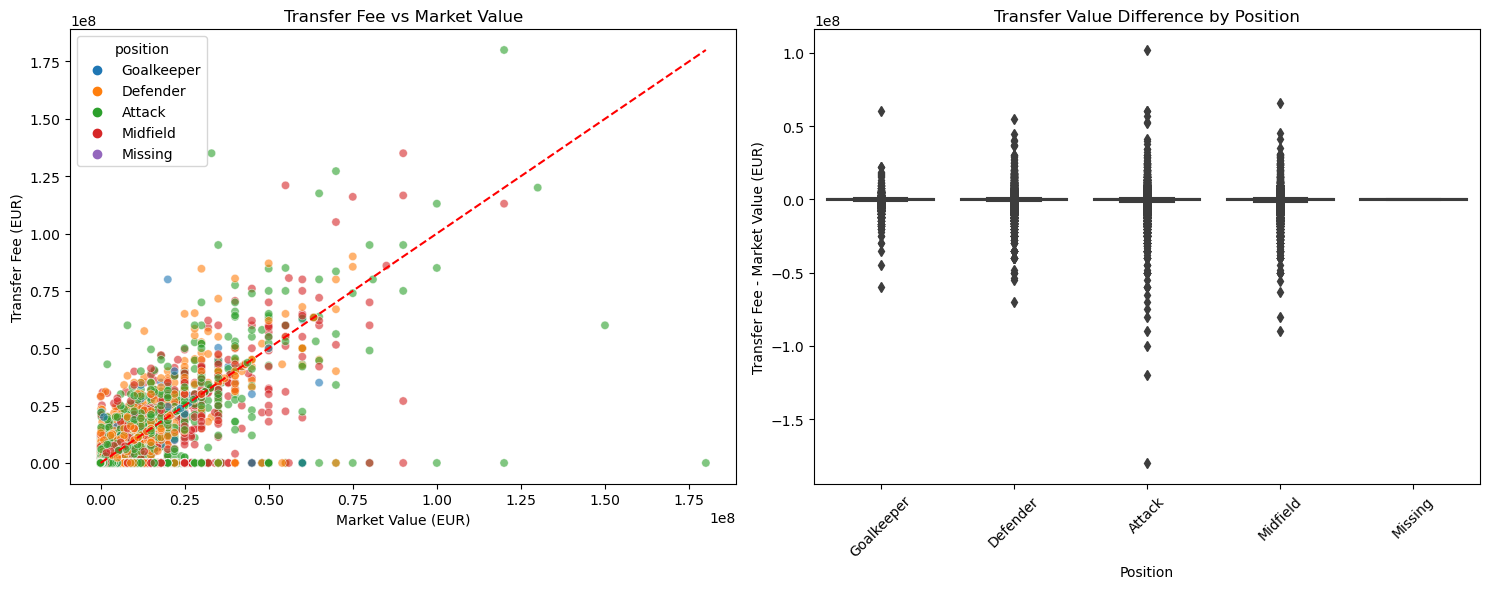


Top 5 Most Overvalued Transfers:
         position  transfer_diff  season
27363      Attack    102000000.0    2017
54136    Midfield     66000000.0    2022
16822  Goalkeeper     60000000.0    2018
33158      Attack     60000000.0    2018
52012      Attack     60000000.0    2022

Top 5 Most Undervalued Transfers:
       position  transfer_diff  season
33159    Attack   -180000000.0    2024
33157    Attack   -120000000.0    2017
39394    Attack   -100000000.0    2024
5513   Midfield    -90000000.0    2019
40642    Attack    -90000000.0    2022


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate transfer fee difference
transfers_data['transfer_diff'] = transfers_data['transfer_fee'] - transfers_data['market_value_in_eur']

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of Transfer Fee vs Market Value
sns.scatterplot(data=transfers_data,
                x='market_value_in_eur',
                y='transfer_fee',
                hue='position',
                alpha=0.6,
                ax=ax1)
ax1.plot([0, transfers_data['market_value_in_eur'].max()],
         [0, transfers_data['market_value_in_eur'].max()],
         'r--', label='Equal Value Line')
ax1.set_title('Transfer Fee vs Market Value')
ax1.set_xlabel('Market Value (EUR)')
ax1.set_ylabel('Transfer Fee (EUR)')

# Box plot of transfer difference by position
sns.boxplot(data=transfers_data,
           x='position',
           y='transfer_diff',
           ax=ax2)
ax2.set_title('Transfer Value Difference by Position')
ax2.set_xlabel('Position')
ax2.set_ylabel('Transfer Fee - Market Value (EUR)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics of most over/under valued transfers
print("\nTop 5 Most Overvalued Transfers:")
print(transfers_data.nlargest(5, 'transfer_diff')[['position', 'transfer_diff', 'season']])

print("\nTop 5 Most Undervalued Transfers:")
print(transfers_data.nsmallest(5, 'transfer_diff')[['position', 'transfer_diff', 'season']])

In [35]:
costly_transfers = (transfers_data
   .nlargest(5, 'transfer_diff')
   .merge(
       players[['player_id', 'name']],
       on='player_id',
       how='left'
   )
   .merge(
       transfers[['player_id', 'from_club_id', 'to_club_id', 'season', 'from_club_name', 'to_club_name']],
       on=['player_id', 'from_club_id', 'to_club_id', 'season'],
       how='left'
   )[['name', 'position','sub_position', 'transfer_diff', 'season', 'from_club_name', 'to_club_name', 'transfer_fee', 'market_value_in_eur']]
   .head()
)
costly_transfers

,name,position,sub_position,transfer_diff,season,from_club_name,to_club_name,transfer_fee,market_value_in_eur
0,Ousmane Dembélé,Attack,Right Winger,102000000.0,2017,Bor. Dortmund,Barcelona,135000000.0,33000000.0
1,Enzo Fernández,Midfield,Central Midfield,66000000.0,2022,Benfica,Chelsea,121000000.0,55000000.0
2,Kepa Arrizabalaga,Goalkeeper,Goalkeeper,60000000.0,2018,Athletic,Chelsea,80000000.0,20000000.0
3,Kylian Mbappé,Attack,Centre-Forward,60000000.0,2018,Monaco,Paris SG,180000000.0,120000000.0
4,Antony,Attack,Right Winger,60000000.0,2022,Ajax,Man Utd,95000000.0,35000000.0


In [36]:
cheap_transfers = (transfers_data
   .nsmallest(5, 'transfer_diff')
   .merge(
       players[['player_id', 'name']],
       on='player_id',
       how='left'
   )
   .merge(
       transfers[['player_id', 'from_club_id', 'to_club_id', 'season', 'from_club_name', 'to_club_name']],
       on=['player_id', 'from_club_id', 'to_club_id', 'season'],
       how='left'
   )[['name', 'position','sub_position', 'transfer_diff', 'season', 'from_club_name', 'to_club_name', 'transfer_fee', 'market_value_in_eur']]
   .head()
)
cheap_transfers

,name,position,sub_position,transfer_diff,season,from_club_name,to_club_name,transfer_fee,market_value_in_eur
0,Kylian Mbappé,Attack,Centre-Forward,-180000000.0,2024,Paris SG,Real Madrid,0.0,180000000.0
1,Kylian Mbappé,Attack,Centre-Forward,-120000000.0,2017,Paris SG,Monaco,0.0,120000000.0
2,Victor Osimhen,Attack,Centre-Forward,-100000000.0,2024,Napoli,Galatasaray,0.0,100000000.0
3,Philippe Coutinho,Midfield,Attacking Midfield,-90000000.0,2019,Barcelona,Bayern Munich,0.0,90000000.0
4,Erling Haaland,Attack,Centre-Forward,-90000000.0,2022,Bor. Dortmund,Man City,60000000.0,150000000.0


### Let's visualize spendings by clubs for each season

In [37]:
temp_df = transfers_data.merge(
       transfers[['player_id', 'from_club_id', 'to_club_id', 'season', 'from_club_name', 'to_club_name']],
       on=['player_id', 'from_club_id', 'to_club_id', 'season'],
       how='left'
   )

clubs_season_transfer_spendings = temp_df.groupby(['season', 'to_club_name'])['transfer_fee'].sum().reset_index().sort_values('transfer_fee', ascending=False)

clubs_season_transfer_spendings = clubs_season_transfer_spendings.rename(columns={ "to_club_name" : "club" })

clubs_season_transfer_spendings['transfer_fee'] = clubs_season_transfer_spendings['transfer_fee'] / 1000000

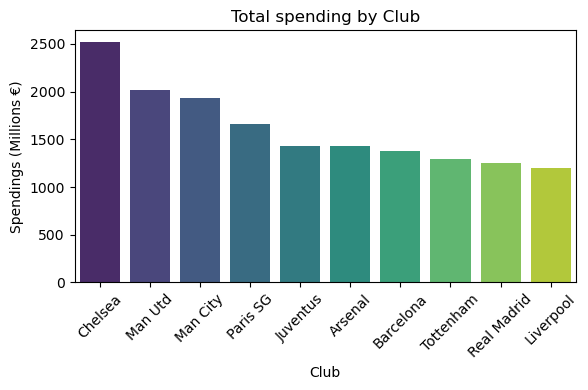

In [38]:
# Bar plot of transfer fees by club (with color palette)
plt.figure(figsize=(6, 4))
sns.barplot(data=clubs_season_transfer_spendings.groupby(['club']).transfer_fee.sum().sort_values(ascending=False).nlargest(10).reset_index(), x='club', y='transfer_fee', palette='viridis',)
plt.title('Total spending by Club')
plt.xlabel('Club')
plt.ylabel('Spendings (Millions €)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Let's check trend of spendings by season

c:\Users\devdp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\devdp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\devdp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\devdp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

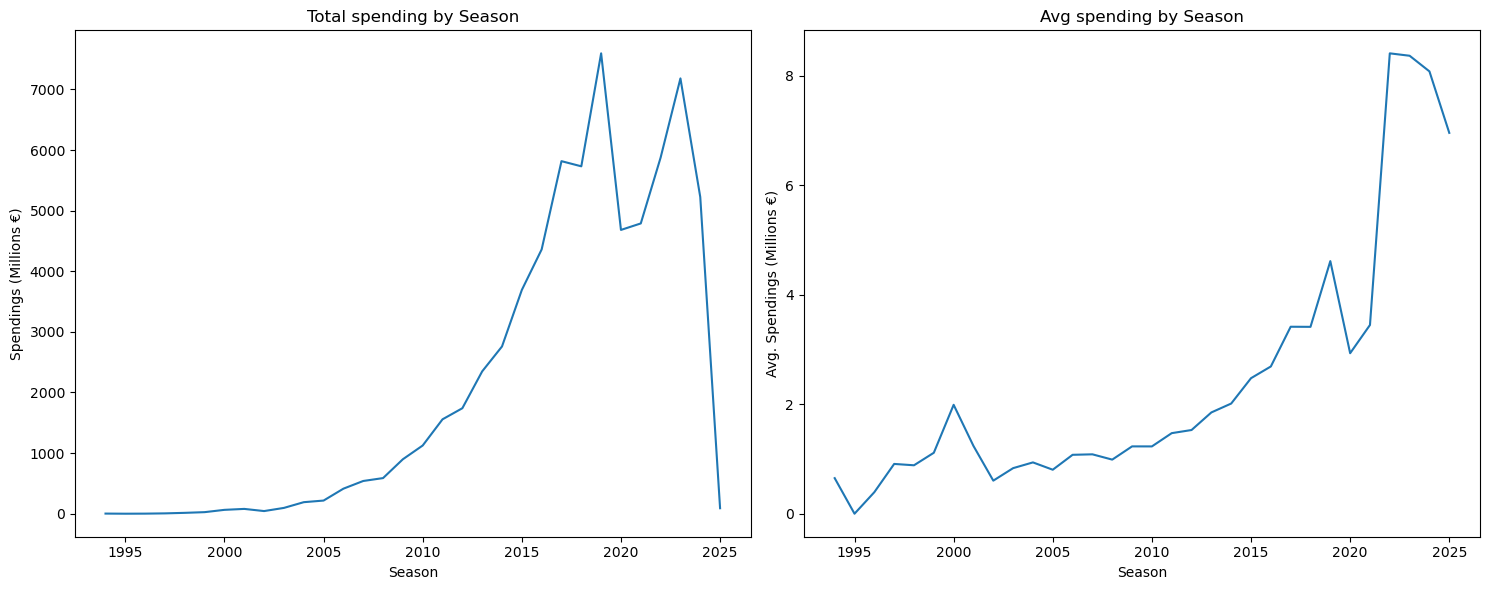

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=clubs_season_transfer_spendings.groupby(['season']).transfer_fee.agg(['sum', 'mean']).reset_index(), x='season', y='sum', ax=axes[0])
axes[0].set_title('Total spending by Season')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Spendings (Millions €)')


sns.lineplot(data=clubs_season_transfer_spendings.groupby(['season']).transfer_fee.agg(['sum', 'mean']).reset_index(), x='season', y='mean', ax=axes[1])
axes[1].set_title('Avg spending by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Avg. Spendings (Millions €)')
plt.tight_layout()
plt.show()

### Saving the data into csv

In [40]:
transfers_data.to_csv('transfers_data.csv', index=False)